<a href="https://colab.research.google.com/github/eldapere8/Datathons/blob/main/GirlsGoneWireless_r1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WIDS Datathon 2021: Predicting Diabetes 
By *GirlsGoneWireless*: Ana Parra Vera   |   Elda Pere


## ✏️ Pre-processing

### Import Libraries

In [ ]:
pip install octopus-ml

In [ ]:
import pandas as pd
import numpy as np
from google.colab import (drive, files)
from datetime import datetime, timedelta
import os
import matplotlib.pyplot as plt
import seaborn as sns
import octopus_ml as oc

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [ ]:
# connect to the drive
drive.mount('/content/gdrive', force_remount=True)
path = "/content/gdrive"
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
# ana
% ls MyDrive/Data\ Science/WIDS\ Datathon/DATA

ls: cannot access 'MyDrive/Data Science/WIDS Datathon/DATA': No such file or directory


In [ ]:
# elda
% ls MyDrive/Projects/WIDS\ Datathon

 DATA/
 DataDictionaryWiDS2021.gsheet
 GirlsGoneWireless_r1.ipynb
 GirlsGoneWireless_v4.ipynb
 GirlsGoneWireless_v5.ipynb
 GirlsGoneWireless_v6.ipynb
 GirlsGoneWireless_v7.ipynb
 GirlsGoneWireless_v8.ipynb
 GirlsGoneWireless_v9.ipynb
 Notes.gdoc
'Phase II'/
'Prev Notebooks'/
 Research.gdoc
 TrainTestSplitAndCrossValidation.ipynb
'Webinar Notes.gdoc'
 wids2021-initial-eda-and-tuned-lgbm-0-86269.ipynb
'WIDs changes.gsheet'
 wids_eda.html
 WIDS_EDA.ipynb


In [ ]:
## choose appropriate path and uncomment below

filepath = 'MyDrive/Projects/WIDS Datathon/DATA/'
# filepath = 'MyDrive/Data Science/WIDS Datathon/DATA/'

### Read the Data

In [ ]:
wids_train_df = pd.read_csv(filepath+'TrainingWiDS2021.csv',index_col=0)

In [ ]:
wids_test_df = pd.read_csv(filepath+'UnlabeledWiDS2021.csv',index_col=0)

### Data Preview

In [ ]:
# checking the columns are the same in the train and test dfs
test_cols = wids_test_df.columns.tolist()
train_cols = wids_train_df.columns.tolist()
train_cols.remove('diabetes_mellitus')

# sanity check
train_cols == test_cols

NameError: ignored

In [ ]:
# we should see 130,157 encounters represented here
wids_train_df.shape

(130157, 180)

In [ ]:
# preview of the data
wids_train_df.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,...,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,...,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,...,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


<Figure size 720x288 with 0 Axes>

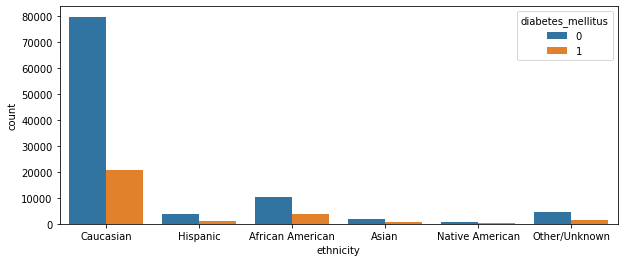

In [ ]:
# distribution of ethnicity
plt.figure(figsize=(10,4))
sns.countplot(x="ethnicity", data=wids_train_df, hue="diabetes_mellitus")

<Figure size 576x216 with 0 Axes>

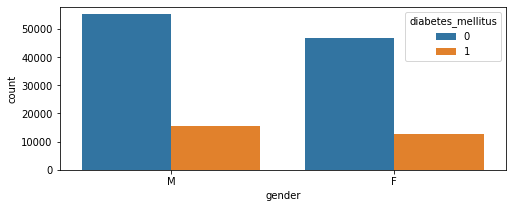

In [ ]:
plt.figure(figsize=(8,3))
sns.countplot(x="gender", data=wids_train_df, hue="diabetes_mellitus")

## ⚙️ Feature Engineering



### Fix Data Types

In [ ]:
def fix_data_types(cat_cols, bin_cols, num_cols, df):
  df.loc[:,cat_cols] = df.loc[:,cat_cols].astype('category')
  df.loc[:,bin_cols] = df.loc[:,bin_cols].astype(bool)
  # print(df[num_cols].dtypes.nunique())
  return df

### Missing Values

Below we fix data types and deal with missing values, removing the variables with more than 90% missing cells, and imputing the remaining quantitative variables. The missing values are imputed when the model is trained. 

In [ ]:
def remove_percent_missing(df, pct=0.99):
  for i in df.columns:
    percent_missing = df[[i]].isnull().sum()/df.shape[0]
    if percent_missing[0] > pct:
      df.drop(columns = [i], inplace=True)
      # print("dropped",i)
  return df

### Calculated BMI

Due to the discrepancies between the values of the BMI variable and the BMI values we calculated using height and weight data, we chose to add the calculated BMI as a variable, as well as the difference between the two so that it may capture a patient's body changes in the cases when the given BMI was taken a long time ago. 

In [ ]:
def add_bmi(df):
  # add calculated BMI variable to dataframe
  df["calculated_bmi"] = df['weight']/(df["height"]/100)**2

  # add difference of BMI and calculated BMI as variable
  df["bmi_difference"] = df["bmi"] - df["calculated_bmi"]

  # add additional columns with nonlinear transformations of bmi
  #df["bmi_squared"] = df["bmi"]**2 NVM BAD

  #df["bmi_log"] = np.log(df["bmi"]) NVM BAD

  return df

### BMI by Ethnicity and Gender

After speaking to medical professionals and researching the relationship between BMI and diabetes, we found that much of the bias in machine learning models come from using the standard white male BMI as a feature. Below, we added BMI values for overweight and obese diabetic individuals categorized by the ethnicities and genders given in the training data.

The BMI values were taken from the [Supplementary Data](https://care.diabetesjournals.org/content/diacare/suppl/2019/09/03/dc19-0532.DC1/DC190532SupplementaryData.pdf) of the [journal](https://care.diabetesjournals.org/content/42/12/2211) *Racial/Ethnic Disparities in the Prevalence of Diabetes and Prediabetes by BMI: Patient Outcomes Research To Advance Learning (PORTAL) Multisite Cohort of Adults in the U.S.* by Yeyi Zhu, Margo A. Sidell, David Arterburn, Matthew F. Daley, Jay Desai, Stephanie L. Fitzpatrick, Michael A. Horberg, Corinna Koebnick, Emily McCormick, Caryn Oshiro, Deborah R. Young, and Assiamira Ferrara.

In [ ]:
def gender_ethnicity_overweight(df):
  """
  Calculating whether a patient is considered overweight based on their BMI,  
  gender and ethnicity.
  """
  if df['gender'] == 'F':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 7.8 and df['calculated_bmi'] < 14.1
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 15.9 and df['calculated_bmi'] < 21.2
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 16.6 and df['calculated_bmi'] < 23.4
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 16.4 and df['calculated_bmi'] < 24.9
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 14.1 and df['calculated_bmi'] < 21.4
    else:
      return df['calculated_bmi'] >= 11.8 and df['calculated_bmi'] < 18.4
  
  elif df['gender'] == 'M':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 10.9 and df['calculated_bmi'] < 18.6
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 20.0 and df['calculated_bmi'] < 27.1
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 21.2 and df['calculated_bmi'] < 27.9
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 20.5 and df['calculated_bmi'] < 28.0
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 17.2 and df['calculated_bmi'] < 24.6
    else:
      return df['calculated_bmi'] >= 15.0 and df['calculated_bmi'] < 22.6
  else:
    return np.nan 

def gender_ethnicity_obese(df):
  """
  Calculating whether a patient is considered obese based on their BMI,  
  gender and ethnicity.
  """
  if df['gender'] == 'F':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >= 14.1
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 21.2
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 23.4
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 24.9
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >= 21.4
    else:
      return df['calculated_bmi'] >= 18.4
  
  elif df['gender'] == 'M':
    if df['ethnicity'] == 'Caucasian':
      return df['calculated_bmi'] >=  18.6
    elif df['ethnicity'] == 'African American':
      return df['calculated_bmi'] >= 27.1
    elif df['ethnicity'] == 'Hispanic':
      return df['calculated_bmi'] >= 27.9
    elif df['ethnicity'] == 'Asian':
      return df['calculated_bmi'] >= 28.0
    elif df['ethnicity'] == 'Native American':
      return df['calculated_bmi'] >=  24.6
    else:
      return df['calculated_bmi'] >= 22.6
  else:
    return np.nan 

In [ ]:
def ethnicity_gender_bmi(df):
  """
  Adding boolean variable: 1 if BMI > x (overweight/obese), 
  0 otherwise. Where x depends on ethnicity and gender.
  """
    
  df["overweight_by_type"] = df[['calculated_bmi', 'ethnicity', 'gender']].apply(gender_ethnicity_overweight, axis = 1)
  df["obese_by_type"] = df[['calculated_bmi', 'ethnicity', 'gender']].apply(gender_ethnicity_obese, axis = 1)
  return df


### Drop Columns

In [ ]:
def drop_columns(df, test_df=False):
  uninteresting_features = ['lymphoma',
                            'ventilated_apache', 'apache_3j_diagnosis', 'map_apache', 
                            'pao2_apache', 'apache_post_operative','aids','temp_apache','leukemia',
                            'solid_tumor_with_metastasis','hospital_admit_source','icu_id']
  # remove old BMI to avoid multicollinearity
  # df.drop(columns=['bmi'], inplace=True)

  # df.drop(uninteresting_features, axis=1, inplace=True)
  if test_df:
    # not dropping the encounter ID since it's needed for labeling submission df
    return df.drop(labels=['readmission_status', 'hospital_id'], axis=1)
  else:
    # dropping IDs and empty variable
    return df.drop(labels=['encounter_id','readmission_status', 'hospital_id'], axis=1)
  # return df

### Separate by Variable Type

Separate the variables into binary, categorical and numerical feature lists and use them to pass the datasets through the pipeline of functions created in the Feature Engineering section. 

In [ ]:
#Binary columns; 
bin_cols = ['overweight_by_type', 'obese_by_type',
            'hepatic_failure','immunosuppression','intubated_apache',
            'arf_apache','cirrhosis','gender','elective_surgery',
            'gcs_unable_apache']

# uninteresting
bin_cols += ['lymphoma','leukemia','ventilated_apache', 'apache_post_operative',
             'aids', 'solid_tumor_with_metastasis']

In [ ]:
#Categorical columns;
# can include hostpital ID later
cat_cols = ['icu_type', 'ethnicity', 'icu_admit_source', 'icu_stay_type', 'apache_2_diagnosis']

cat_cols += ['hospital_admit_source', 'apache_3j_diagnosis']

In [ ]:
num_cols = list(set(wids_train_df.columns).difference(set(bin_cols)).difference(set(cat_cols)))

# other_num_cols = list(set(interesting_features).difference(set(bin_cols)).difference(set(cat_cols)))
# other_num_cols += ['calculated_bmi', 'bmi_difference']

# uninteresting
# other_num_cols += ['map_apache', 'pao2_apache', 'temp_apache', 'icu_id']

In [ ]:
#All features;
all_features = bin_cols + cat_cols + num_cols

In [ ]:
# uninteresting columns based on research
uninteresting_features = list(set(wids_train_df.columns).difference(set(all_features)))

In [ ]:
len(uninteresting_features)

0

### Fix Age as 0

In [ ]:
# filling zeroes with mean
# wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].mean()
wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].median()
# wids_train_df.loc[wids_train_df['age']==0,'age'] = wids_train_df['age'].mode()


### Pipeline for each ethnicity/gender dataset

In [ ]:
#Create a separate dataframe for each ethnicity and each gender. 

#Ethnicities
caucasian = wids_train_df[wids_train_df['ethnicity'] == 'Caucasian']
hispanic = wids_train_df[wids_train_df['ethnicity'] == 'Hispanic']
african_american = wids_train_df[wids_train_df['ethnicity'] == 'African American']
asian = wids_train_df[wids_train_df['ethnicity'] == 'Asian']
native_american = wids_train_df[wids_train_df['ethnicity'] == 'Native American']

#Genders
male = wids_train_df[wids_train_df['gender'] == 'M']
female = wids_train_df[wids_train_df['gender'] == 'F']

#List of each dataframe
all_dfs = {'caucasian':caucasian, 'hispanic': hispanic, 'african_american': african_american, 'asian': asian, 'native_american': native_american, 'male': male, 'female': female}

In [ ]:
#Run pipeline for each dataframe. Note ethnicity_gender_bmi returns all trues and so the columns are removed when getting dummies. 
train_dfs = {}

for key in all_dfs.keys():
  train_dfs[key] = drop_columns(remove_percent_missing(fix_data_types(cat_cols, 
                                                           bin_cols, num_cols, 
                                                           ethnicity_gender_bmi(add_bmi(all_dfs[key]))),0.91))

  # create dummy vars based on categorical and binary variables
  train_dfs[key] = pd.get_dummies(data=train_dfs[key], columns=cat_cols+bin_cols, drop_first=True)
  print(train_dfs[key].shape)

  # hard coding apache 3j diagnosis col missing in training data
  train_dfs[key]['apache_3j_diagnosis_1703.06'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

(100236, 634)
(5049, 531)
(13911, 595)
(2198, 478)
(915, 411)
(70518, 626)
(59573, 624)


## 🔥 Modeling

### Separate by Variable Type

Below, we split the data into a training and test set. We separate the variables into binary, categorical and numerical feature lists and use them to pass the datasets through the pipeline of functions created in the Feature Engineering section. 

In [ ]:
#Split into training and test sets
tr = {}
te = {}
target = {}
for key in train_dfs.keys():
  tr[key], te[key] = train_test_split(train_dfs[key], test_size=0.3, random_state=83)
  target[key] = tr[key]['diabetes_mellitus']
  tr[key]=tr[key].drop(columns = ['diabetes_mellitus'])

In [ ]:
#Check
te['asian'].shape[0] + tr['asian'].shape[0] == train_dfs['asian'].shape[0]

True

### Training the Model

In [ ]:
#Run the model for each dataframe
clf= {}
arr_f1_weighted = {}
arr_f1_macro = {}
arr_f1_positive = {}
prediction_folds = {}
preds_folds = {}
y_folds = {}

for key in tr.keys():  
  params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.004,
          'subsample': 1,
          'colsample_bytree': 0.2,
          'reg_alpha': 3,
          'reg_lambda': 1,
          'scale_pos_weight': 5,
          'n_estimators': 10000,
          'verbose': 1,
          'max_depth': -1,
          'seed':100, 
          'force_col_wise': True,
          "num_leaves":36
          #'objective': 'binary',
          #'boosting': 'gbdt',        
          #'learning_rate': 0.01,
          #'seed': 100,
          #'scale_pos_weight': 0.1,
          #'categorical_feature': 'auto'
          # 'metric': 'auc',
          # 'scale_pos_weight':0.1,
          # 'learning_rate': 0.02,
          # 'num_boost_round':2000,
          # "min_sum_hessian_in_leaf":1,
          # 'max_depth' : 100,
          # "bagging_freq": 2,
          # "bagging_fraction" : 0.4,
          # "feature_fraction" : 0.05
  }

  clf[key],arr_f1_weighted[key],arr_f1_macro[key],arr_f1_positive[key],prediction_folds[key],preds_folds[key],y_folds[key]= oc.cv(tr[key],target[key],
                                                                                              0.5,10000,shuffle=True,params=params)


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
5it [32:02, 384.58s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 4.037487MB
Peak                : 957.435027MB
Total time taken:   1922947.144 ms 


5it [05:17, 63.43s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 0.278235MB
Peak                : 73.575395MB
Total time taken:   317142.226 ms 


5it [11:58, 143.74s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 0.611278MB
Peak                : 126.388816MB
Total time taken:   718708.478 ms 


5it [02:24, 28.95s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 0.135669MB
Peak                : 40.184003MB
Total time taken:   144782.195 ms 


5it [01:13, 14.70s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 0.088924MB
Peak                : 17.447645MB
Total time taken:   73514.279 ms 


5it [25:53, 310.69s/it]
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Method Name       : cv
Current memory usage: 2.609132MB
Peak                : 667.62601MB
Total time taken:   1553491.618 ms 


5it [26:13, 314.80s/it]

Method Name       : cv
Current memory usage: 2.224692MB
Peak                : 561.362884MB
Total time taken:   1574006.664 ms 


In [ ]:
for key in tr.keys(): 
  print(classification_report(y_folds[key], prediction_folds[key]))


              precision    recall  f1-score   support

           0       0.93      0.81      0.87     55628
           1       0.52      0.77      0.62     14537

    accuracy                           0.80     70165
   macro avg       0.72      0.79      0.74     70165
weighted avg       0.84      0.80      0.82     70165

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2644
           1       0.59      0.60      0.60       890

    accuracy                           0.80      3534
   macro avg       0.73      0.73      0.73      3534
weighted avg       0.80      0.80      0.80      3534

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      7163
           1       0.57      0.64      0.61      2574

    accuracy                           0.78      9737
   macro avg       0.72      0.73      0.73      9737
weighted avg       0.79      0.78      0.78      9737

              preci

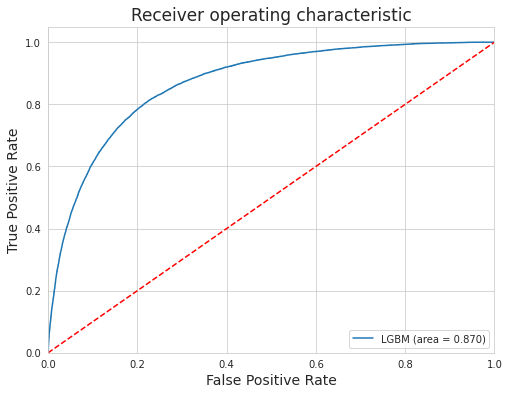

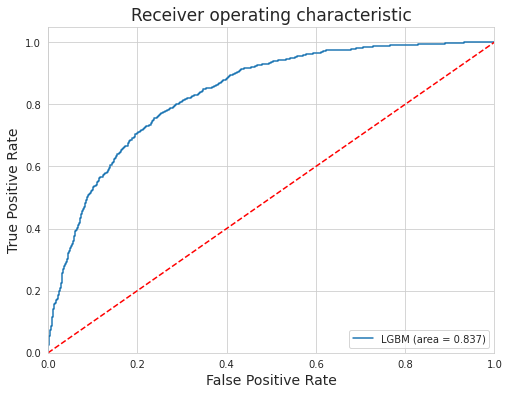

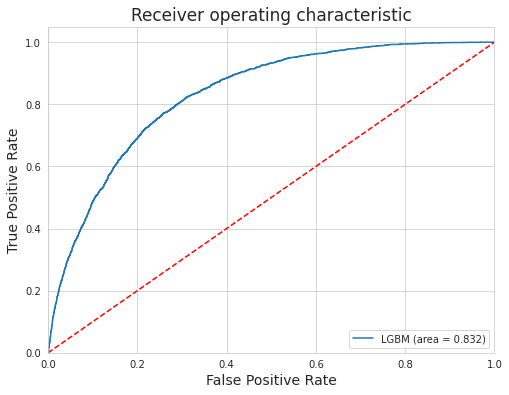

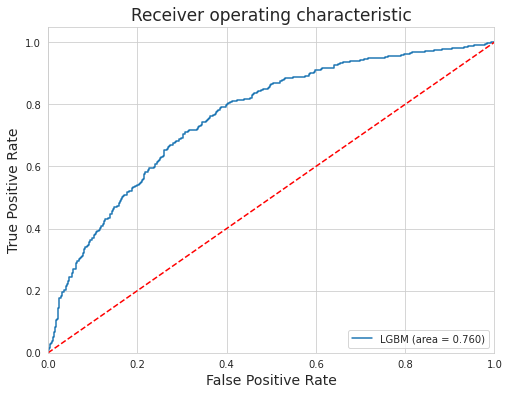

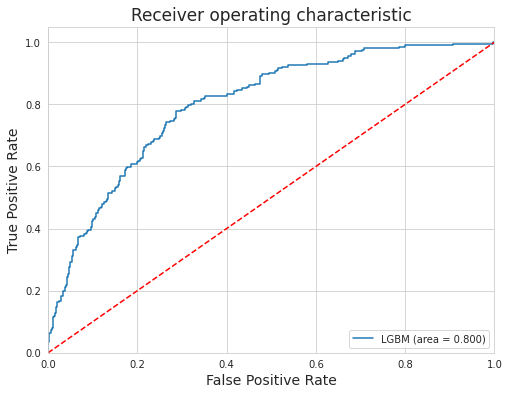

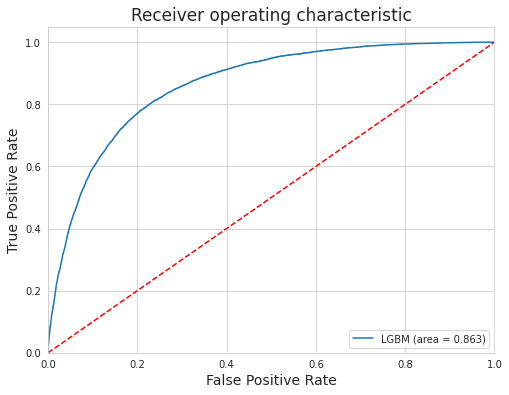

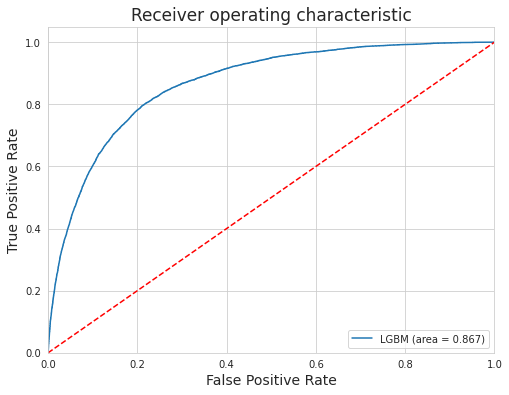

In [ ]:
for key in tr.keys(): 
  oc.roc_curve_plot(y_folds[key],preds_folds[key])


In [ ]:
for key in tr.keys(): 
  roc_auc_score(y_folds[key],preds_folds[key])

0.869895668293163

0.8367709802988322

0.8316559423637463

0.7601147884952851

0.8003978480039785

0.8633569018303777

0.8671820162865855

## ➡️ Test set predictions

In [ ]:
te_preds = {}
te_target = {}
for key in te.keys():    
    te_target[key]= te[key].pop('diabetes_mellitus')
    #if 'diabetes_mellitus' in te[key].columns:
     #   te_target[key] = te[key].drop(['diabetes_mellitus'],axis=1)
    te_preds[key]=clf[key].predict(te[key][tr[key].columns.tolist()])

In [ ]:
for key in te.keys(): 
  print(key + ' roc score:' + str(roc_auc_score(te_target[key], te_preds[key])))


caucasian roc score:0.8746917031437869
hispanic roc score:0.8340094493717485
african_american roc score:0.8435640067993009
asian roc score:0.7846468021906619
native_american roc score:0.8154549774293182
male roc score:0.8655777718164039
female roc score:0.8673973856267594


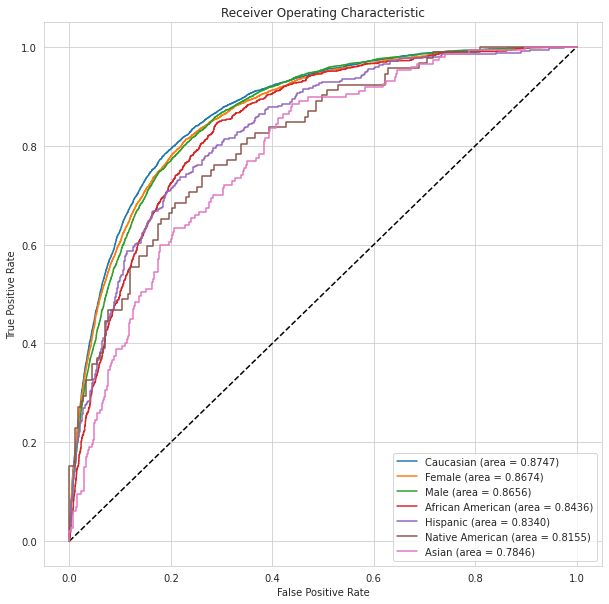

In [ ]:
#ROC Curve
from sklearn.metrics import roc_curve
fpr1 , tpr1, thresholds1 = roc_curve(te_target['caucasian'], te_preds['caucasian'])

fpr2 , tpr2, thresholds2 = roc_curve(te_target['hispanic'], te_preds['hispanic'])

fpr3 , tpr3, thresholds3 = roc_curve(te_target['african_american'], te_preds['african_american'])

fpr4 , tpr4, thresholds4 = roc_curve(te_target['asian'], te_preds['asian'])

fpr5 , tpr5, thresholds5 = roc_curve(te_target['native_american'], te_preds['native_american'])

fpr6 , tpr6, thresholds6 = roc_curve(te_target['male'], te_preds['male'])

fpr7 , tpr7, thresholds7 = roc_curve(te_target['female'], te_preds['female'])



plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Caucasian (area = " + '0.8747' + ")")
plt.plot(fpr7, tpr7, label= "Female (area = " + '0.8674' + ")")
plt.plot(fpr6, tpr6, label= "Male (area = " + '0.8656' + ")")
plt.plot(fpr3, tpr3, label= "African American (area = " + '0.8436' + ")")
plt.plot(fpr2, tpr2, label= "Hispanic (area = " + '0.8340' + ")")
plt.plot(fpr5, tpr5, label= "Native American (area = " + '0.8155' + ")")
plt.plot(fpr4, tpr4, label= "Asian (area = " + '0.7846' + ")")

plt.legend();
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate");
plt.title('Receiver Operating Characteristic');
plt.rcParams["figure.figsize"] = (10,10);
plt.show();